In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
from scipy.optimize import minimize

In [40]:
Nhomework = 10

rng = np.random.default_rng()
i = rng.integers(0, Nhomework)+1
print(i)

1


(2, 100000)


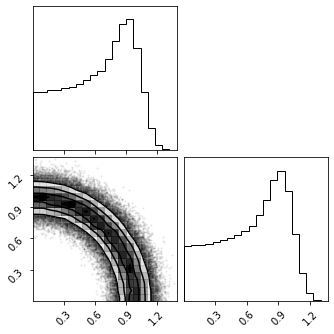

In [41]:
# Parameters transformations with samples


Nsample = int(1e5)

phi = rng.uniform(low=0, high=np.pi/2, size=Nsample)

mu_r = 1
sigma_r = 0.1

r = mu_r + sigma_r*rng.normal(size=Nsample)

sample = np.vstack((r*np.cos(phi), r*np.sin(phi)))

print(sample.shape)

figure = corner.corner(sample.T)


In [42]:
# Homework: draw points (x1, x2, x3) uniformly on the 2-sphere 
# (that is ||x|| = 1). Make a corner plot. Check the plot: is the results
# correct?! -- think about the volume element, think about symmetries

(3, 100000)


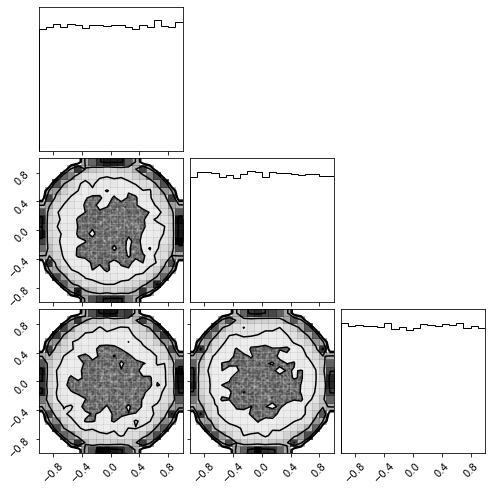

In [75]:
Nsample = int(1e5)

phi = np.random.uniform(0, 2 * np.pi, Nsample) 
cos_theta = np.random.uniform(-1, 1, Nsample)  
theta = np.arccos(cos_theta) 

x1 = np.sin(theta) * np.cos(phi)
x2 = np.sin(theta) * np.sin(phi)
x3 = np.cos(theta)

sample = np.vstack((x1, x2, x3))

print(sample.shape)

figure = corner.corner(sample.T)

- Pairwise Distributions:
In the corner plot, the 2D histograms for 
(
𝑥
1
,
𝑥
2
)
(x 
1
​
 ,x 
2
​
 ), 
(
𝑥
1
,
𝑥
3
)
(x 
1
​
 ,x 
3
​
 ), and 
(
𝑥
2
,
𝑥
3
)
(x 
2
​
 ,x 
3
​
 ) should show circular or elliptical symmetry because the points lie on the surface of a sphere.
 
- Marginal Distributions:
Each of 
𝑥
1
x 
1
​
 , 
𝑥
2
x 
2
​
 , and 
𝑥
3
x 
3
​
  should show a symmetric, bell-shaped distribution centered at 0. The distribution should not be uniform because the density of points in Cartesian space is highest near the equator of the sphere.

In [44]:
class RejectionSampler:
    
    def __init__(self, pdf, bounds, seed=1492):
        """
        pdf: log of the callable function from which we want 
        to sample
        bounds: (ndim, 2), upper and lower 
        bounds of the sampling
        """
        self.p = pdf
        
        self.start = bounds[:, 0]
        self.width = bounds[:, 1] - bounds[:, 0]
        
        self._rng = np.random.default_rng(seed=seed)
    
        
    def __call__(self, N):
        """
        N: number of iterations
        """
        
        pmax = self._find_max()
        
        sample = []
        for i in range(N):
            point = self._a_step(pmax)
            if point is not None: # if we got a point
                if len(sample)==0: # if it is the first point
                    sample = point.copy()
                else:
                    sample = np.vstack((sample, point))
        return sample
       
    def _find_max(self):
        
        f = lambda x: -self.p(x)
        guess = self.start + 0.5*self.width
        
        res = minimize(f, guess, tol=0.1)
        
        if res.success:
            return self.p(res.x)
        else:
            raise ValueError('maximum not found')
            
    def _a_step(self, pmax):
        
        rand = self._rng.uniform(size=len(self.start))
        prop = self.start + rand*self.width
        
        p_i = self.p(prop) - pmax
        
        # dummy variable
        u = self._rng.uniform()
        if u<np.exp(p_i):
            return prop
        else:
            pass
        
        
        

       

In [45]:
# create an instance of the class
logprob = lambda x: -0.5*np.sum(x**2)
bounds = np.ones((10, 2))

sampler = RejectionSampler(logprob, bounds)

In [46]:
# check attributes of the class
print(sampler)
print(sampler.p)
print(sampler.p(np.ones(10)))
print(sampler.start)
print(sampler.width)
print(sampler._rng)
print(sampler(10))

<function <lambda> at 0x7fa451236280>
-5.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Generator(PCG64)
[]


In [47]:
sampler = RejectionSampler(logprob, np.array([ [-5, 5],
                                               [-5, 5] ]))

(6202, 2)


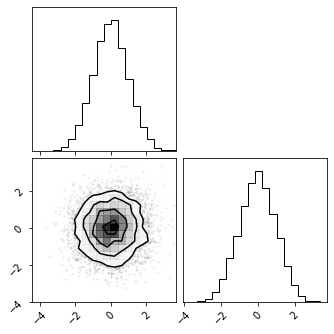

In [48]:
Niter = 100000

sample = sampler(Niter)

figure = corner.corner(sample)
print(sample.shape)

In [ ]:
# very inefficient....

In [49]:
# lets modify our sample to define the bounds using the 
# estimates of the uncertainty from the hessian of the 
# maximisation

class BetterRejectionSampler(RejectionSampler):
    
    def __init__(self, pdf, guess, sigma=4):
        
        
        
    def _find_max(self):
        
       


IndentationError: expected an indented block (3214535117.py, line 11)

In [50]:
# we shall track the acceptance rate of the sampling of 
# a multi-variate standard Gaussian within a 3-sigma box
# for different dimensions

ndims = np.arange(2, 15)

Niter = int(1e5)

def logMultivariateGaussian(params):
    
    return -0.5*np.sum(params**2)

accep = []

for ndim in ndims:
    bounds = np.vstack( (-3*np.ones(ndim), 3*np.ones(ndim)) ).T
    sampler = RejectionSampler(logMultivariateGaussian,
                              bounds)
    sample = sampler(Niter)

    try:
        accep.append(sample.shape[0]/Niter)
    except AttributeError:
        print(sample)
        accep.append(0)



[]
[]


Text(0, 0.5, 'acceptance rate')

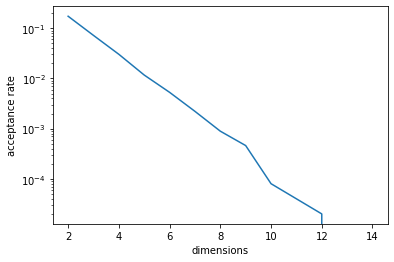

In [51]:
plt.plot(ndims, accep)
plt.yscale('log')
plt.xlabel('dimensions')
plt.ylabel('acceptance rate')



Text(0, 0.5, 'accep')

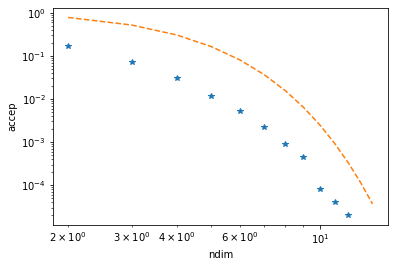

In [52]:
from scipy.special import gamma

ratio = np.pi**(ndims/2) / gamma(ndims/2 +1) / 2**ndims

plt.figure()
plt.plot(ndims, accep, '*')
plt.plot(ndims, ratio, '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ndim')
plt.ylabel('accep')


In [54]:
class MetropolisHastingsSampler:
    
    def __init__(self, lnp, seed=1492):
        
        self.lnp = lnp
        self._rng = np.random.default_rng(seed=seed)

    def __call__(self, prop, Niter, start):
        """
        prop: generate a proposal point given a starting point
        start: starting point of the sampler
        Niter: number of iterations
        """
        
        points = [start, ]
        count = 0
        
        for i in range(Niter):
            x_prop = prop(start)
            xnew, accept = self._a_step(x_prop, start)
            count += accept
            points.append(xnew)
            
            start = xnew
        
        return np.array(points), count/Niter
    
    def _a_step(self, x_prop, x_old):
        
        alpha = np.exp( self.lnp(x_prop) - self.lnp(x_old) )
        
        u = self._rng.uniform()
        
        if u<alpha:
            return x_prop, 1
        else:
            return x_old, 0
        
      
        
        

In [55]:
Niter = int(1e5)

sampler_mh = MetropolisHastingsSampler(logMultivariateGaussian)

def GaussianProp(y, prop_sigma=1):
    return y + prop_sigma*rng.normal(size=len(y))

pnts, accept = sampler_mh(GaussianProp, Niter, 5*np.ones(4))

print(accept)

0.37664


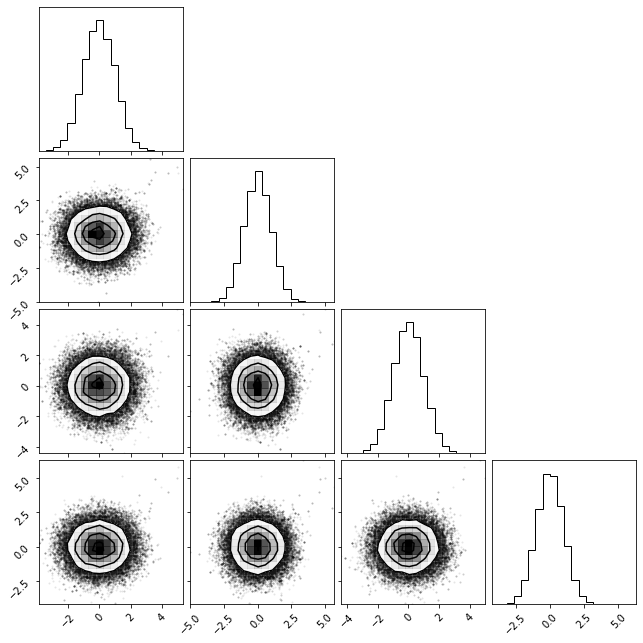

In [57]:
figure = corner.corner(pnts)

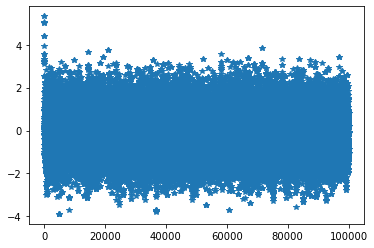

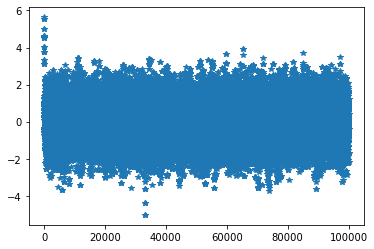

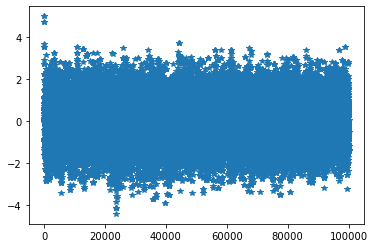

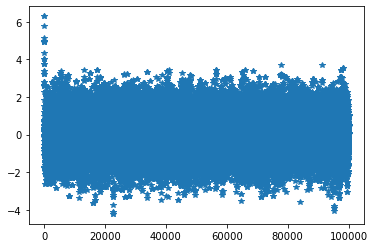

In [58]:
# traceplots

for i in range(pnts.shape[1]):
    plt.figure()
    plt.plot(pnts[:, i], '*')

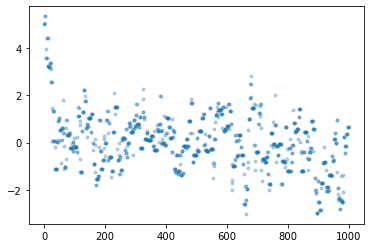

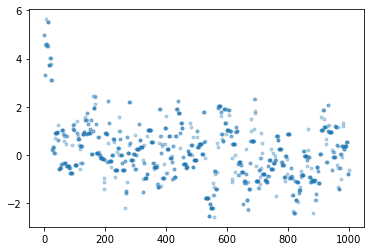

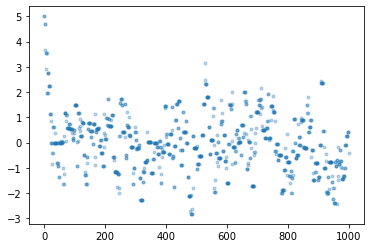

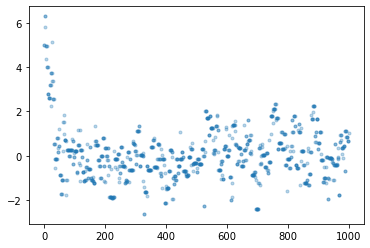

In [59]:
# traceplots

for i in range(pnts.shape[1]):
    plt.figure()
    plt.plot(pnts[:1000, i], '.', alpha=0.3)

In [60]:
def _get_acorr(pnts, t):
    
    mu = np.mean(pnts, axis=0)
    if t==0:
        autocorr = np.mean( (pnts - mu[None, :])**2 )
    else:
        autocorr = np.mean( (pnts[:-t] - mu[None, :]) * \
                            (pnts[t:] - mu[None, :]) )
        
    return autocorr

def acorr(pnts, taumax=100):
    
    res = np.zeros((taumax))
    
    for i in range(taumax):
        res[i] = _get_acorr(pnts, i)
    
    return res, np.sum(res/res[0])
  
  


In [61]:
print(acorr(pnts)[1])


7.796175501240702


In [62]:
Niter = int(1e4)

prop_sigma = np.geomspace(0.1, 5, num=20)

acceps = np.zeros(len(prop_sigma))
taus = np.zeros(len(prop_sigma))

for i in range(len(prop_sigma)):
    f_prop = lambda y: y + prop_sigma[i]*rng.normal(size=len(y))
    pnts, accep = sampler_mh(f_prop, Niter, np.zeros(4))
    
    acceps[i] = accep
    taus[i] = acorr(pnts)[1]


Text(0, 0.5, 'taus')

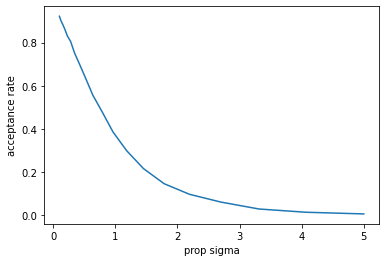

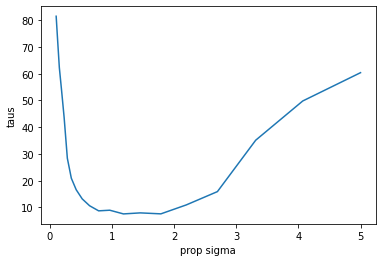

In [63]:
# systematically explore the trend in the
# autocorrelation time and the acceptance rate when 
# changing the variance of the proposal distribution
# from 0.03^2 to 3^2

plt.figure()
plt.plot(prop_sigma, acceps)
plt.xlabel('prop sigma')
plt.ylabel('acceptance rate')


plt.figure()
plt.plot(prop_sigma, taus)
plt.xlabel('prop sigma')
plt.ylabel('taus')

In [15]:
# Homework: run the same test of sampling 
# a highdimensional Gaussian with metropolis Hastings.
# Probe different, ever increasing dimensions.
# Plot the acceptance rate against the dimension
# and the inverse correlation time against dimension

# What do you observe?

# Modify the variance in the proposal distribution, and 
# check if making the proposal distribution too large or 
# too narrow changes this behaviour.




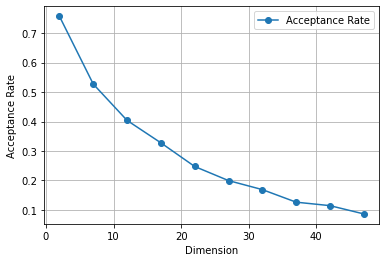

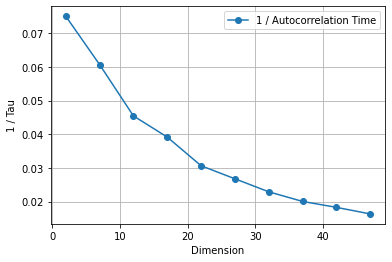

In [68]:
class MetropolisHastingsSampler:
    def __init__(self, lnp, seed=1492):
        self.lnp = lnp
        self._rng = np.random.default_rng(seed=seed)

    def __call__(self, prop, Niter, start):
        points = [start]
        count = 0

        for i in range(Niter):
            x_prop = prop(start)
            xnew, accept = self._a_step(x_prop, start)
            count += accept
            points.append(xnew)
            start = xnew

        return np.array(points), count / Niter

    def _a_step(self, x_prop, x_old):
        alpha = np.exp(self.lnp(x_prop) - self.lnp(x_old))
        u = self._rng.uniform()

        if u < alpha:
            return x_prop, 1
        else:
            return x_old, 0

def _get_acorr(pnts, t):
    mu = np.mean(pnts, axis=0)
    if t == 0:
        autocorr = np.mean((pnts - mu[None, :]) ** 2)
    else:
        autocorr = np.mean((pnts[:-t] - mu[None, :]) * (pnts[t:] - mu[None, :]))
    return autocorr


def acorr(pnts, taumax=100):
    res = np.zeros((taumax))
    for i in range(taumax):
        res[i] = _get_acorr(pnts, i)
    return res, np.sum(res / res[0])


def logMultivariateGaussian(x):
    return -0.5 * np.sum(x**2)



dimensions = np.arange(2, 50, 5)  
Niter = int(1e4)  
prop_sigma = 0.5   

acceptance_rates = []
inverse_taus = []

for dim in dimensions:
    sampler_mh = MetropolisHastingsSampler(logMultivariateGaussian)

    def GaussianProp(y, prop_sigma=prop_sigma):
        return y + prop_sigma * np.random.normal(size=len(y))

    start_point = np.zeros(dim)  

    pnts, accep = sampler_mh(GaussianProp, Niter, start_point)
    _, tau = acorr(pnts)

    acceptance_rates.append(accep)
    inverse_taus.append(1 / tau)  

    
plt.figure()
plt.plot(dimensions, acceptance_rates, marker="o", label="Acceptance Rate")
plt.xlabel("Dimension")
plt.ylabel("Acceptance Rate")
plt.legend()
plt.grid()

plt.figure()
plt.plot(dimensions, inverse_taus, marker="o", label="1 / Autocorrelation Time")
plt.xlabel("Dimension")
plt.ylabel("1 / Tau")
plt.legend()
plt.grid()

plt.show()


## Acceptance Rate and Dimension:

- As the dimension increases, the acceptance rate decreases. 
- This is because the sampling space becomes significantly larger in higher dimensions, reducing the probability of accepting proposed samples.

## Inverse Correlation Time and Dimension:

- As the dimension increases, the correlation time increases (the value of 1/𝜏 decreases).
- This indicates that the chain requires more effort to explore the sampling space effectively.

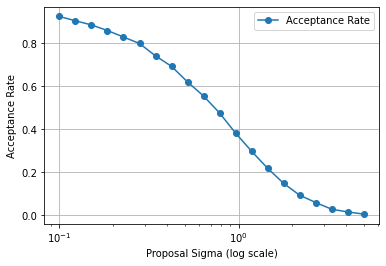

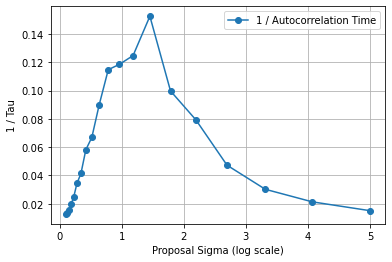

In [76]:
Niter = int(1e4)

dimension = 4

prop_sigmas = np.geomspace(0.1, 5, num=20)  

acceptance_rates = []
inverse_taus = []

sampler_mh = MetropolisHastingsSampler(logMultivariateGaussian)

for sigma in prop_sigmas:
    def GaussianProp(y, prop_sigma=sigma):
        return y + prop_sigma * np.random.normal(size=len(y))

    start_point = np.zeros(dimension)
    pnts, accep = sampler_mh(GaussianProp, Niter, start_point)
    _, tau = acorr(pnts)

    acceptance_rates.append(accep)
    inverse_taus.append(1 / tau)  

plt.figure()
plt.plot(prop_sigmas, acceptance_rates, marker="o", label="Acceptance Rate")
plt.xscale("log")
plt.xlabel("Proposal Sigma (log scale)")
plt.ylabel("Acceptance Rate")
plt.legend()
plt.grid()

plt.figure()
plt.plot(prop_sigmas, inverse_taus, marker="o", label="1 / Autocorrelation Time")
#plt.xscale("log")
plt.xlabel("Proposal Sigma (log scale)")
plt.ylabel("1 / Tau")
plt.legend()
plt.grid()

plt.show()


## Acceptance Rate and Dimension:
- As the dimension increases, the acceptance rate decreases.  
- This happens because the sampling space becomes significantly larger in higher dimensions, reducing the probability of accepting proposed samples.

## Inverse Correlation Time and Dimension:
- As the dimension increases, the **correlation time** increases (the value of \(1/\tau\) decreases).  
- This indicates that the Markov chain requires more effort to effectively explore the sampling space.
